In [1]:
import torch, os, datetime, torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms 
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random
import pandas as pd
import time
from sklearn.metrics import precision_score, recall_score, f1_score

import seaborn as sns

In [2]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Carregando e seperando dataset

In [4]:
batch_size = 32

# Transformações para normalizar o dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Carregando o dataset MNIST
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# DataLoader para o dataset de treinamento e teste
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

classes = list(map(str, range(0, 10)))

##### Visualizando dados

In [5]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


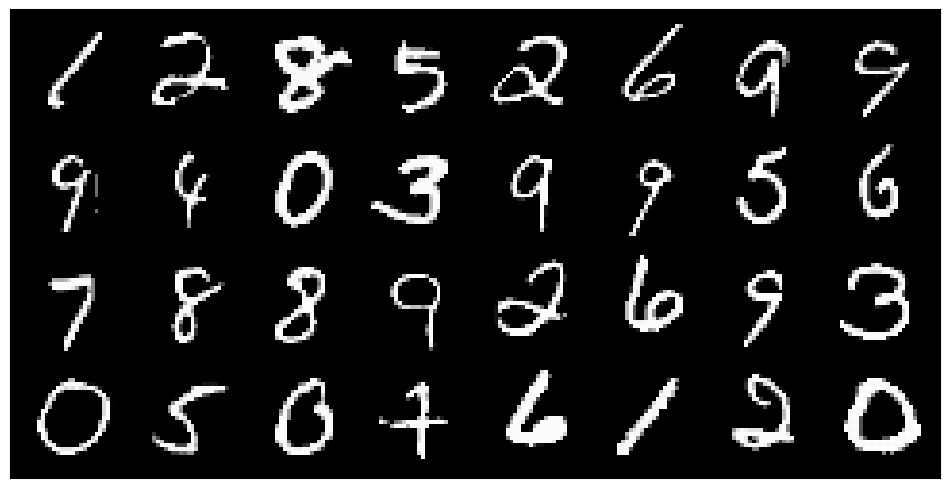

In [6]:
show_batch(trainloader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


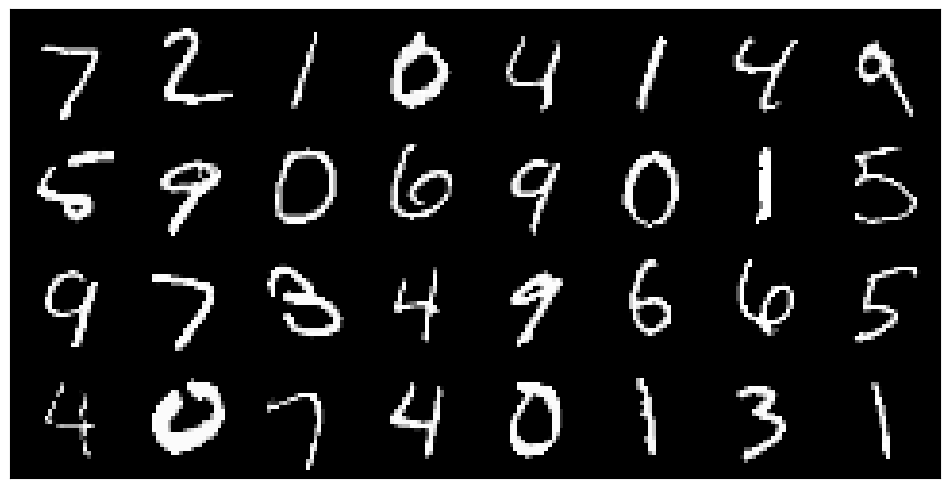

In [7]:
show_batch(testloader)

## Criando uma instância da classe nn.Module para criar redes

#### Explicando cada parâmetro da camada convolucional:

- **in_channels**: Quantos canais de cores os inputs possuem. No caso de imagens em preto e branco, como estamos trabalhando com MNIST, há apenas um canal de cor.

- **out_channels**: Número de filtros (kernels) que serão aplicados à imagem durante a convolução. Cada filtro é responsável por extrair características latentes da imagem.

- **kernel_size**: Dimensão do filtro utilizado na convolução. O valor comum de 3 é amplamente usado, pois é suficiente para capturar detalhes locais, ao mesmo tempo em que percebe padrões maiores na imagem.

- **stride**: Indica de quanto em quantos pixels o filtro será aplicado na imagem.

- **padding**: Adiciona pixels em volta da imagem de entrada durante a convolução para garantir que o tamanho da saída após a convolução permaneça o mesmo que o da entrada.
  - *Observação*: Ao adicionar padding, é preciso ter cuidado com os valores para garantir que a resolução e o tamanho da imagem não sejam afetados de forma indesejada.

- **dropout_prob**: Probabilidade de que um neurônio seja desligado durante o treinamento da rede. Isso é uma técnica de regularização que ajuda a prevenir o overfitting, forçando a rede a aprender representações mais robustas e generalizáveis.

#### Fórmulas das Dimensões de Saída

A fórmula para calcular a dimensão de saída \( W_out \) da convolução é:

$$
W_{\text{out}} = \left\lfloor \frac{W_{\text{in}} + 2 \times \text{padding} - \text{kernel\_size}}{\text{stride}} \right\rfloor + 1
$$

E a fórmula para calcular a dimensão de saída \( H_out \) da convolução é:

$$
H_{\text{out}} = \left\lfloor \frac{H_{\text{in}} + 2 \times \text{padding} - \text{kernel\_size}}{\text{stride}} \right\rfloor + 1
$$

Resumindo as trasnformações:

- Entrada Original: 28x28 pixels, 1 canal.
- Após Convolução: 28x28 pixels, 32 canais.
- Após Pooling: 14x14 pixels, 32 canais.
- Entrada para self.fc1: 32 × 14 × 14

In [8]:
class BaseCNN(nn.Module):
    def __init__(self, conv_kernel_size=3, conv_stride=1, conv_padding=1, pool_kernel_size=2, pool_stride=2, dropout_prob=0.5):
        super(BaseCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=conv_kernel_size, stride=conv_stride, padding=conv_padding)
        self.pool = nn.MaxPool2d(kernel_size=pool_kernel_size, stride=pool_stride)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc1 = nn.Linear(32 * 14 * 14, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = x.view(-1, 32 * 14 * 14)
        x = self.fc1(x)
        return x

In [9]:
class DeepCNN(nn.Module):
    def __init__(self, conv_kernel_size=3, conv_stride=1, conv_padding=1, pool_kernel_size=2, pool_stride=2, dropout_prob=0.5):
        super(DeepCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=conv_kernel_size, stride=conv_stride, padding=conv_padding)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=conv_kernel_size, stride=conv_stride, padding=conv_padding)
        self.pool = nn.MaxPool2d(kernel_size=pool_kernel_size, stride=pool_stride)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [10]:
class CNN(nn.Module):
    def _calc_conv_output_size(self, in_size, kernel_size, conv_stride, pool_size, pool_stride, padding):
        # Apply convolution
        out_size = (in_size + 2 * padding - kernel_size) // conv_stride + 1
        # Apply pooling
        out_size = (out_size - pool_size) // pool_stride + 1
        return out_size

    def __init__(self, trial, num_conv_layers, num_filters, num_neurons, drop_conv2, drop_prob_fc1,
                 conv_kernel_size=3, pool_kernel_size=2, conv_stride=1, pool_stride=2, padding=0):
        super(CNN, self).__init__()

        in_size = 28

        self.convs = nn.ModuleList([nn.Conv2d(1, num_filters[0],
                                              kernel_size=(conv_kernel_size, conv_kernel_size),
                                              stride=conv_stride, padding=padding)])
        out_size = self._calc_conv_output_size(in_size, conv_kernel_size, conv_stride,
                                               pool_kernel_size, pool_stride, padding)

        for i in range(1, num_conv_layers):
            self.convs.append(nn.Conv2d(in_channels=num_filters[i - 1], out_channels=num_filters[i],
                                        kernel_size=(conv_kernel_size, conv_kernel_size),
                                        stride=conv_stride, padding=padding))
            out_size = self._calc_conv_output_size(out_size, conv_kernel_size, conv_stride,
                                                   pool_kernel_size, pool_stride, padding)

        if out_size <= 0:
            raise ValueError("Output size is too small after convolution and pooling operations. " +
                             "Adjust the kernel sizes and strides.")

        self.conv2_drop = nn.Dropout2d(p=drop_conv2)
        self.out_feature = num_filters[num_conv_layers - 1] * out_size * out_size
        self.pool = nn.MaxPool2d(kernel_size=pool_kernel_size, stride=pool_stride)
        self.fc1 = nn.Linear(self.out_feature, num_neurons)
        self.fc2 = nn.Linear(num_neurons, 10)
        self.fc1_drop_prob = drop_prob_fc1

    def forward(self, x):
        for i, conv in enumerate(self.convs):
            x = conv(x)
            if i == 2:
                x = self.conv2_drop(x)
            x = F.relu(self.pool(x))

        x = x.view(-1, self.out_feature)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self.fc1_drop_prob, training=self.training)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

# Definindo funções úteis

#### Função de treinamento do modelo

In [11]:
def train_model(model, criterion, optimizer, epochs):
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0

        for inputs, labels in trainloader:
            (inputs, labels) = (inputs.to(device), labels.to(device))
            optimizer.zero_grad()
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()  # Propaga os gradientes
            optimizer.step()  # Atualiza os pesos

            running_loss += loss.item()

        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}')
    
    print('Finished Training!')

#### Função de teste do modelo

In [12]:
def test_model(model, criterion):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = correct / total
    loss = test_loss / len(testloader)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    return accuracy, loss, precision, recall, f1

#### Função de acurácia de cada classe

In [13]:
# Mudar
def accuracy_classes(model_trained):
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    all_accuracy = []

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_trained(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1


    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        all_accuracy.append(accuracy)
    
    return all_accuracy

#### Função para prever classe de uma imagem

In [14]:
def predict_image(image_path, model):
    image = Image.open(image_path).convert('L')  
    transform = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor()
    ])

    # Adiciona dimensão de batch (1 imagem)
    image = transform(image).unsqueeze(0) 

    # Passando a imagem pela rede
    output = model(image).to(device)

    _, predicted_class = torch.max(output, 1)
    print("Classe prevista:", predicted_class.item())


#### Definindo cvs com os parametros e metricas

In [15]:
if (os.path.exists('cnn_models_metrics.csv')):
    model_df = pd.read_csv('cnn_models_metrics.csv')
else:
    model_data = {
        'network': [],
        'conv_kernel_size': [],
        'conv_stride': [],
        'conv_padding': [],
        'pool_kernel_size': [],
        'pool_stride': [],
        'dropout_prob': [],
        'fit_time': [],
        'precision': [],
        'recall': [],
        'f1_score': [],
        'overall_accuracy ': [],
        'accuracy_0': [],
        'accuracy_1': [],
        'accuracy_2': [],
        'accuracy_3': [],
        'accuracy_4': [],
        'accuracy_5': [],
        'accuracy_6': [],
        'accuracy_7': [],
        'accuracy_8': [],
        'accuracy_9': [],
        'total_epochs': [],
        'learning_rate': [],
    }
    model_df = pd.DataFrame(model_data)

# Fine-Tuning de Hiperparâmetros

In [16]:
import optuna
from optuna.trial import TrialState

num_epochs = 5
num_trials = 3
criterion = nn.CrossEntropyLoss().to(device)

def train_model_once(model, criterion, optimizer):
    model.train().to(device)

    running_loss = 0.0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()  # Propaga os gradientes
        optimizer.step()  # Atualiza os pesos

        running_loss += loss.item()
 
    return running_loss / len(trainloader)

def objective(trial):
    # Define range of values to be tested for the hyperparameters
    num_conv_layers = trial.suggest_int("num_conv_layers", 1, 3)
    num_filters = [int(trial.suggest_discrete_uniform("num_filter_" + str(i), 16, 128, 16))
                   for i in range(num_conv_layers)]
    num_neurons = trial.suggest_int("num_neurons", 10, 400, 10)  # Number of neurons of fully connected layer 1
    drop_conv2 = trial.suggest_float("drop_conv2", 0.2, 0.5)     # Dropout for convolutional layer 2
    drop_fc1 = trial.suggest_float("drop_prob_fc1", 0.2, 0.5)    # Dropout probability for fully connected layer 1

    # conv_kernel_size, conv_stride, padding, pool_kernel_size, pool_stride
    params_list = [
        (3, 1, 1, 2, 2),
        (5, 1, 2, 2, 2),
        (3, 1, 1, 2, 2),
    ]

    params = random.choice(params_list)

    conv_kernel_size = params[0]
    conv_stride = params[1]
    padding = params[2]
    pool_kernel_size = params[3]
    pool_stride = params[4]

    # Manually add these parameters to the trial's attributes
    trial.set_user_attr("conv_kernel_size", conv_kernel_size)
    trial.set_user_attr("conv_stride", conv_stride)
    trial.set_user_attr("conv_padding", padding)
    trial.set_user_attr("pool_kernel_size", pool_kernel_size)
    trial.set_user_attr("pool_stride", pool_stride)

    # Generate the model
    model = CNN(trial, num_conv_layers, num_filters, num_neurons, drop_conv2, drop_fc1,
                conv_kernel_size, pool_kernel_size, conv_stride, pool_stride, padding).to(device)

    # Generate the optimizer
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    # Train the model
    for epoch in range(num_epochs):
        train_loss = train_model_once(model, criterion, optimizer)
        accuracy, test_loss, precision, recall, f1 = test_model(model, criterion)

        print(f"Epoch {epoch + 1}, " +
              f"Train Loss: {train_loss:.4f}, " + 
              f"Test Loss: {test_loss:.4f}")

        # Pruning (stops trial early if not promising)
        trial.report(accuracy, epoch)
        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    trial.set_user_attr("accuracy", accuracy)
    trial.set_user_attr("test_loss", test_loss)
    trial.set_user_attr("precision", precision)
    trial.set_user_attr("recall", recall)
    trial.set_user_attr("f1_score", f1)

    current_datetime = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
    path_model_trained = os.path.join('modelos_treinados', f'optune{current_datetime}.pth')
    torch.save(model.state_dict(), path_model_trained)

    return accuracy

c:\Users\Amand\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

[I 2024-05-22 00:39:08,876] A new study created in memory with name: no-name-e1827fe8-262a-4148-af8e-e3dac87e557d
C:\Users\Amand\AppData\Local\Temp\ipykernel_21360\1120127470.py:29: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_" + str(i), 16, 128, 16))
C:\Users\Amand\AppData\Local\Temp\ipykernel_21360\1120127470.py:31: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_neurons = trial.suggest_int("num_neurons", 10, 400, 10)  # Number of neurons of fully connected layer 1


Epoch 1, Train Loss: 0.4858, Test Loss: 0.2212
Epoch 2, Train Loss: 0.1976, Test Loss: 0.1419
Epoch 3, Train Loss: 0.1406, Test Loss: 0.1110
Epoch 4, Train Loss: 0.1120, Test Loss: 0.0881


[I 2024-05-22 00:41:14,958] Trial 0 finished with value: 0.9779 and parameters: {'num_conv_layers': 1, 'num_filter_0': 64.0, 'num_neurons': 380, 'drop_conv2': 0.4120135938152488, 'drop_prob_fc1': 0.22997658176276148, 'optimizer': 'Adam', 'lr': 2.746129282480339e-05}. Best is trial 0 with value: 0.9779.


Epoch 5, Train Loss: 0.0921, Test Loss: 0.0746


C:\Users\Amand\AppData\Local\Temp\ipykernel_21360\1120127470.py:29: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_" + str(i), 16, 128, 16))
C:\Users\Amand\AppData\Local\Temp\ipykernel_21360\1120127470.py:31: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_neurons = trial.suggest_int("num_neurons", 10, 400, 10)  # Number of neurons of fully connected layer 1


Epoch 1, Train Loss: 1.4092, Test Loss: 0.4410
Epoch 2, Train Loss: 0.4963, Test Loss: 0.2043
Epoch 3, Train Loss: 0.3238, Test Loss: 0.1453
Epoch 4, Train Loss: 0.2515, Test Loss: 0.1143


[I 2024-05-22 00:43:16,213] Trial 1 finished with value: 0.9707 and parameters: {'num_conv_layers': 3, 'num_filter_0': 96.0, 'num_filter_1': 64.0, 'num_filter_2': 80.0, 'num_neurons': 60, 'drop_conv2': 0.32489324497002775, 'drop_prob_fc1': 0.35389570449590524, 'optimizer': 'Adam', 'lr': 1.782810495329021e-05}. Best is trial 0 with value: 0.9779.


Epoch 5, Train Loss: 0.2098, Test Loss: 0.0974


C:\Users\Amand\AppData\Local\Temp\ipykernel_21360\1120127470.py:29: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_" + str(i), 16, 128, 16))
C:\Users\Amand\AppData\Local\Temp\ipykernel_21360\1120127470.py:31: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_neurons = trial.suggest_int("num_neurons", 10, 400, 10)  # Number of neurons of fully connected layer 1


Epoch 1, Train Loss: 0.2081, Test Loss: 0.0501
Epoch 2, Train Loss: 0.0574, Test Loss: 0.0351
Epoch 3, Train Loss: 0.0422, Test Loss: 0.0315
Epoch 4, Train Loss: 0.0320, Test Loss: 0.0271


[I 2024-05-22 00:44:19,626] Trial 2 finished with value: 0.991 and parameters: {'num_conv_layers': 2, 'num_filter_0': 64.0, 'num_filter_1': 96.0, 'num_neurons': 310, 'drop_conv2': 0.2546568079402256, 'drop_prob_fc1': 0.23511552322958512, 'optimizer': 'SGD', 'lr': 0.04471058530212346}. Best is trial 2 with value: 0.991.


Epoch 5, Train Loss: 0.0267, Test Loss: 0.0257


# Estatísticas

In [18]:
print("\n-- Study Statistics --")
print(f"  Number of finished trials: {len(study.trials)}")
print(f"  Number of pruned trials:   {len(pruned_trials)}")
print(f"  Number of complete trials: {len(complete_trials)}")

best_trial = study.best_trial
print("\n-- Best Trial --")
print(f"  Accuracy:  {best_trial.value}")
print(f"  Test Loss: {best_trial.user_attrs['test_loss']}")
print(f"  Precision: {best_trial.user_attrs['precision']}")
print(f"  Recall:    {best_trial.user_attrs['recall']}")
print(f"  F1 Score:  {best_trial.user_attrs['f1_score']}")
print("  Parameters: ")
for key, val in best_trial.params.items():
    print(f"    {key}: {(16 - len(key)) * ' '}{val}")
print(f"  conv_kernel_size: {best_trial.user_attrs['conv_kernel_size']}")
print(f"  conv_stride:      {best_trial.user_attrs['conv_stride']}")
print(f"  conv_padding:     {best_trial.user_attrs['conv_padding']}")
print(f"  pool_kernel_size: {best_trial.user_attrs['pool_kernel_size']}")
print(f"  pool_stride:      {best_trial.user_attrs['pool_stride']}")

# Save results to csv file
df = study.trials_dataframe().drop(["datetime_start", "datetime_complete", "duration"], axis=1)
df = df.loc[df["state"] == "COMPLETE"]  # Keep only results that did not prune
df = df.drop("state", axis=1)
df = df.sort_values("value")            # Sort based on accuracy
df.to_csv("optuna_results.csv", index=False)

print(f"\n-- Overall Results (Ordered by Accuracy) --")
print(df)

most_important_parameters = optuna.importance.get_param_importances(study, target=None)

print("\n-- Most Important Hyperparameters --")
for key, val in most_important_parameters.items():
    print(f"  {key}: {(15 - len(key)) * ' '}{(100 * val):.2f}%")


-- Study Statistics --
  Number of finished trials: 3
  Number of pruned trials:   0
  Number of complete trials: 3

-- Best Trial --
  Accuracy:  0.991
  Test Loss: 0.025667962592985268
  Precision: 0.991047823693963
  Recall:    0.991
  F1 Score:  0.9910032803803999
  Parameters: 
    num_conv_layers:  2
    num_filter_0:     64.0
    num_filter_1:     96.0
    num_neurons:      310
    drop_conv2:       0.2546568079402256
    drop_prob_fc1:    0.23511552322958512
    optimizer:        SGD
    lr:               0.04471058530212346
  conv_kernel_size: 3
  conv_stride:      1
  conv_padding:     1
  pool_kernel_size: 2
  pool_stride:      2

-- Overall Results (Ordered by Accuracy) --
   number   value  params_drop_conv2  params_drop_prob_fc1  params_lr  \
1       1  0.9707           0.324893              0.353896   0.000018   
0       0  0.9779           0.412014              0.229977   0.000027   
2       2  0.9910           0.254657              0.235116   0.044711   

   params_nu

# One Model

#### Instânciando o modelo base, definindo parametros, loss function e otimizador

In [19]:
model = BaseCNN().to(device)

learning_rate = 0.001
epochs = 10

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

#### Treinamento o modelo

In [20]:
train_model(model, criterion, optimizer, epochs)

Epoch 1, Loss: 0.384782139168183
Epoch 2, Loss: 0.23831701233883698
Epoch 3, Loss: 0.1912519934932391
Epoch 4, Loss: 0.16461124399056037
Epoch 5, Loss: 0.14714536422590416
Epoch 6, Loss: 0.13749022841975092
Epoch 7, Loss: 0.1272109903064867
Epoch 8, Loss: 0.11995212206194798
Epoch 9, Loss: 0.11432278891926011
Epoch 10, Loss: 0.10794405772338311
Finished Training!


#### Testando o modelo

In [21]:
accuracy, loss, precision, recall, f1 = test_model(model, criterion)
print(f'Accuracy: {100 * accuracy}%, Test Loss: {loss:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

Accuracy: 97.61%, Test Loss: 0.0799, Precision: 0.9762, Recall: 0.9761, F1 Score: 0.9761


## Salvando o modelo treinado

In [22]:
if not os.path.exists('modelos_treinados'):
    os.makedirs('modelos_treinados')

current_datetime = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
path_model_trained = os.path.join('modelos_treinados', f'model_{current_datetime}.pth')

torch.save(model.state_dict(), path_model_trained)

# N Models

#### Função de criação de derivação da rede base

In [23]:
def create_cnn(conv_kernel_size, conv_stride, conv_padding, pool_kernel_size, pool_stride, dropout_prob):
    class CNNTest(BaseCNN):
        def __init__(self):
            super(CNNTest, self).__init__(conv_kernel_size, conv_stride, conv_padding, pool_kernel_size, pool_stride, dropout_prob)
    return CNNTest().to(device)

#### Instanciando os modelos com grid de parametros

In [24]:
grid = [
    {'conv_kernel_size': 3, 'conv_stride': 1, 'conv_padding': 1, 'pool_kernel_size': 2, 'pool_stride': 2, 'dropout_prob': 0.5},
    {'conv_kernel_size': 5, 'conv_stride': 1, 'conv_padding': 2, 'pool_kernel_size': 2, 'pool_stride': 2, 'dropout_prob': 0.3},
    {'conv_kernel_size': 3, 'conv_stride': 1, 'conv_padding': 1, 'pool_kernel_size': 2, 'pool_stride': 2, 'dropout_prob': 0.7}
]
networks = [create_cnn(**params) for params in grid]

#### Definindo parametros adicionais, loss function e otimizadores

In [25]:
learning_rate = 0.001
epochs = 10

criterion = nn.CrossEntropyLoss().to(device)
optimizers = [optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9) for model in networks]

#### Treinando e testando os modelos

In [26]:
for i, net in enumerate(networks):
    print(f"Treinando Rede Neural {i + 1} com os seguintes parâmetros:")
    print(grid[i])

    start = time.time()
    train_model(net, criterion, optimizers[i], epochs)
    end = time.time()
    total_time = round(end - start, 1)

    accuracy, loss, precision, recall, f1 = test_model(net, criterion)
    print(f'Accuracy: {100 * accuracy}% Test Loss: {loss:.4f} Precision: {precision:.4f} Recall: {recall:.4f} F1 Score: {f1:.4f} Fit Time: {total_time}')
    print('------------------------------------\n')

    class_accuracies = accuracy_classes(net)

    model_data  = {
        'network': [], #colocar como é a rede, podemos criar um nome pra cada rede e por ou algo do genero
        **grid[i],
        'fit_time': total_time,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'overall_accuracy ': accuracy,
        'loss': loss,
        'total_epochs': epochs,
        'learning_rate': learning_rate,
    }

    for idx, acc in enumerate(class_accuracies):
        model_data[f'accuracy_{idx}'] = acc

    # Adicionando o modelo ao dataframe de modelos
    model_df.loc[len(model_df)] = model_data

Treinando Rede Neural 1 com os seguintes parâmetros:
{'conv_kernel_size': 3, 'conv_stride': 1, 'conv_padding': 1, 'pool_kernel_size': 2, 'pool_stride': 2, 'dropout_prob': 0.5}
Epoch 1, Loss: 0.35869523210128146
Epoch 2, Loss: 0.22594005839725337
Epoch 3, Loss: 0.1822856837068995
Epoch 4, Loss: 0.15789351285398007
Epoch 5, Loss: 0.1432555805993577
Epoch 6, Loss: 0.13015948122292756
Epoch 7, Loss: 0.12193328732376298
Epoch 8, Loss: 0.11608865336080393
Epoch 9, Loss: 0.11089956559290488
Epoch 10, Loss: 0.10692115652188659
Finished Training!
Accuracy: 97.61% Test Loss: 0.0787 Precision: 0.9761 Recall: 0.9761 F1 Score: 0.9761 Fit Time: 86.3
------------------------------------

Treinando Rede Neural 2 com os seguintes parâmetros:
{'conv_kernel_size': 5, 'conv_stride': 1, 'conv_padding': 2, 'pool_kernel_size': 2, 'pool_stride': 2, 'dropout_prob': 0.3}
Epoch 1, Loss: 0.32763771085739135
Epoch 2, Loss: 0.18061796630422275
Epoch 3, Loss: 0.13966323005060355
Epoch 4, Loss: 0.11693177247196436
Ep

In [27]:
model_df.to_csv('cnn_models_metrics.csv', index=False)

## Carregando modelo treinado

In [28]:
# path_model_trained = 'modelos_treinados\model_20240520_214724.pth'

model_trained = BaseCNN().to(device)
model_trained.load_state_dict(torch.load(path_model_trained))
model_trained.eval()

BaseCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=6272, out_features=10, bias=True)
)

#### Prevendo a classe de uma entrada

#### Analisando acurácia de cada classe

In [29]:
all_accuracy = accuracy_classes(model_trained)
for i, accuracy in enumerate(all_accuracy):
    print(f'Accuracy for class: {i} is {accuracy:.2f} %')

Accuracy for class: 0 is 99.18 %
Accuracy for class: 1 is 99.03 %
Accuracy for class: 2 is 97.58 %
Accuracy for class: 3 is 97.62 %
Accuracy for class: 4 is 98.37 %
Accuracy for class: 5 is 97.09 %
Accuracy for class: 6 is 98.23 %
Accuracy for class: 7 is 97.18 %
Accuracy for class: 8 is 96.41 %
Accuracy for class: 9 is 95.24 %


# Análise dos Resultados

In [43]:
df = pd.read_csv('optuna_results.csv')
df.sort_values(by=['number'], inplace=True)
df.columns

Index(['number', 'value', 'params_drop_conv2', 'params_drop_prob_fc1',
       'params_lr', 'params_num_conv_layers', 'params_num_filter_0',
       'params_num_filter_1', 'params_num_filter_2', 'params_num_neurons',
       'params_optimizer', 'user_attrs_accuracy', 'user_attrs_f1_score',
       'user_attrs_precision', 'user_attrs_recall', 'user_attrs_test_loss'],
      dtype='object')

In [44]:
df

,number,value,params_drop_conv2,params_drop_prob_fc1,params_lr,params_num_conv_layers,params_num_filter_0,params_num_filter_1,params_num_filter_2,params_num_neurons,params_optimizer,user_attrs_accuracy,user_attrs_f1_score,user_attrs_precision,user_attrs_recall,user_attrs_test_loss
2,0,988.0000,0.228622,0.264944,0.000021,2,112.0,32.0,NaN,170,RMSprop,0.9880,0.987991,0.988037,0.9880,0.037004
5,1,0.9938,0.487943,0.413034,0.000157,2,112.0,96.0,NaN,400,Adam,0.9938,0.993796,0.993808,0.9938,0.020710
1,2,0.9668,0.201712,0.319593,0.001284,3,96.0,80.0,32.0,220,SGD,0.9668,0.966771,0.966784,0.9668,0.114243
3,3,991.0000,0.454703,0.329464,0.053301,2,64.0,16.0,NaN,110,SGD,0.9910,0.990996,0.991013,0.9910,0.028702
0,4,0.0982,0.223627,0.387862,0.064700,1,112.0,NaN,NaN,90,Adam,0.0982,0.017562,0.009643,0.0982,2.306228
4,6,0.9911,0.370678,0.291222,0.011220,2,128.0,16.0,NaN,290,SGD,0.9911,0.991099,0.991122,0.9911,0.027628


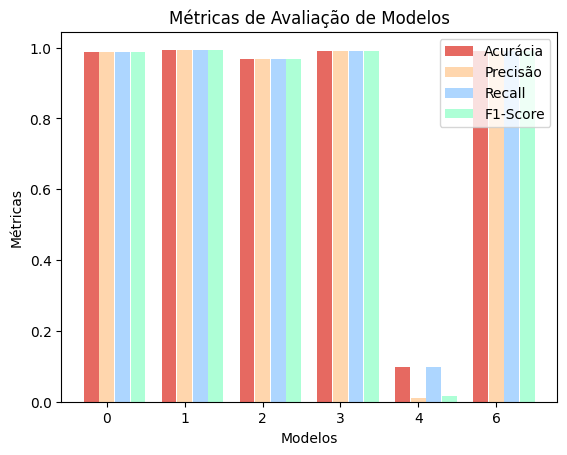

In [45]:
x = np.arange(len(df['number']))
width = 0.2  # Largura das barras

fig, ax = plt.subplots()
bars4 = ax.bar(x - width, df['user_attrs_accuracy'], width - 0.01, label='Acurácia', color=(0.9, 0.41, 0.38))
bars2 = ax.bar(x, df['user_attrs_precision'], width - 0.01, label='Precisão', color=(1.0, 0.8, 0.6, 0.8))
bars1 = ax.bar(x + width, df['user_attrs_recall'], width - 0.01, label='Recall', color=(0.6, 0.8, 1.0, 0.8))
bars3 = ax.bar(x + 2*width, df['user_attrs_f1_score'], width - 0.01, label='F1-Score', color=(0.6, 1.0, 0.8, 0.8))

ax.set_xlabel('Modelos')
ax.set_ylabel('Métricas')
ax.set_title('Métricas de Avaliação de Modelos')
ax.set_xticks(x)
ax.set_xticklabels(df['number'])
ax.legend()

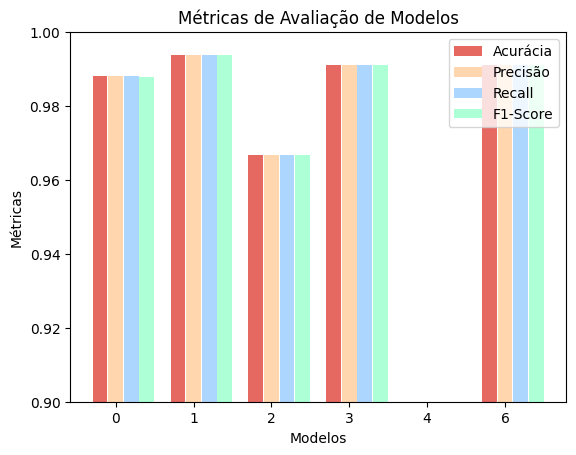

In [46]:
fig, ax = plt.subplots()
bars4 = ax.bar(x - width, df['user_attrs_accuracy'], width - 0.01, label='Acurácia', color=(0.9, 0.41, 0.38))
bars2 = ax.bar(x, df['user_attrs_precision'], width - 0.01, label='Precisão', color=(1.0, 0.8, 0.6, 0.8))
bars1 = ax.bar(x + width, df['user_attrs_recall'], width - 0.01, label='Recall', color=(0.6, 0.8, 1.0, 0.8))
bars3 = ax.bar(x + 2*width, df['user_attrs_f1_score'], width - 0.01, label='F1-Score', color=(0.6, 1.0, 0.8, 0.8))

ax.set_xlabel('Modelos')
ax.set_ylabel('Métricas')
ax.set_title('Métricas de Avaliação de Modelos')
ax.set_xticks(x)
ax.set_xticklabels(df['number'])
ax.set_ylim(0.9, 1.0)
ax.legend()

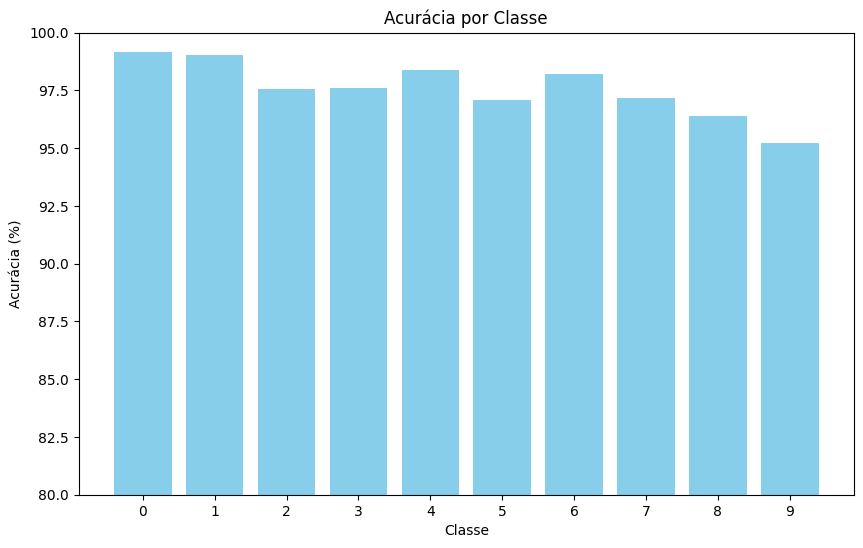

In [47]:
acc_data = pd.DataFrame(all_accuracy, columns=['Acurácia'])

plt.figure(figsize=(10, 6))
plt.bar(acc_data.index, acc_data['Acurácia'], color='skyblue')

# Adicionando títulos e rótulos
plt.title('Acurácia por Classe')
plt.xlabel('Classe')
plt.ylabel('Acurácia (%)')
plt.xticks(acc_data.index)
plt.ylim(80, 100)

# Mostrando o gráfico
plt.show()

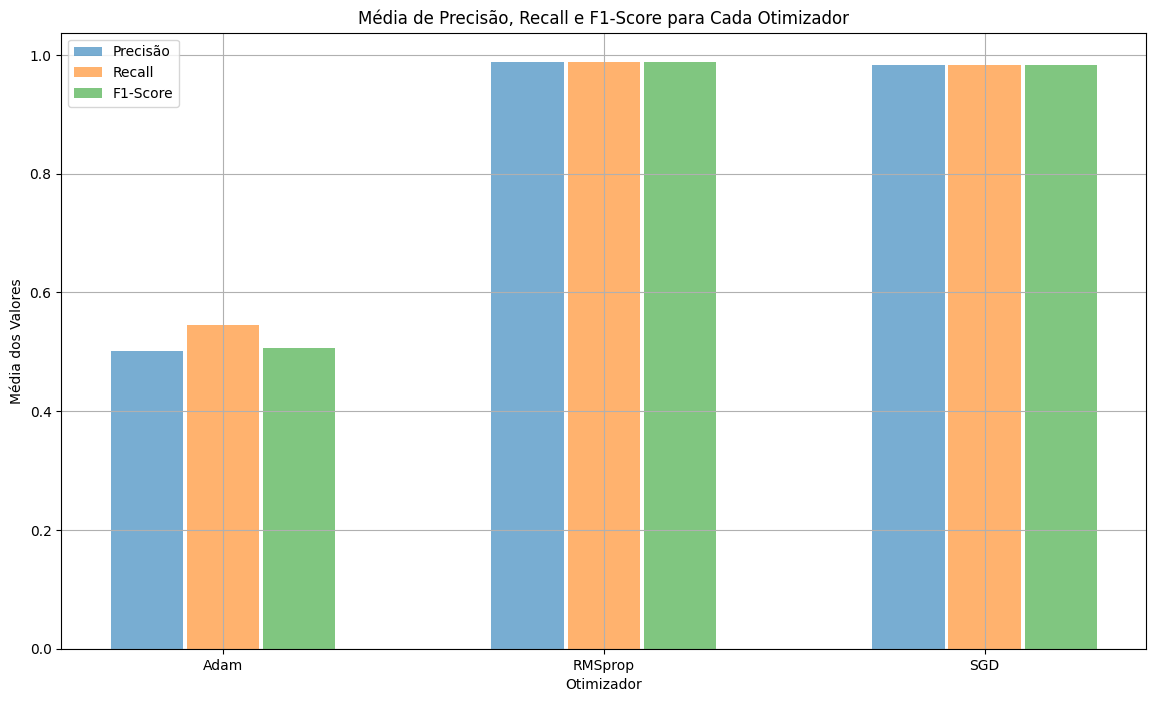

In [48]:
# Agrupar por otimizador e calcular médias
optimizer_group = df.groupby('params_optimizer').mean()

r1 = np.arange(len(optimizer_group.index))
r2 = [x + width for x in r1]
r3 = [x + width for x in r2]


# Gráfico de barras
plt.figure(figsize=(14, 8))

# Precisão
plt.bar(r1, optimizer_group['user_attrs_precision'], width - 0.01, label='Precisão', alpha=0.6)

# Recall
plt.bar(r2, optimizer_group['user_attrs_recall'], width - 0.01, label='Recall', alpha=0.6)

# F1-score
plt.bar(r3, optimizer_group['user_attrs_f1_score'], width - 0.01, label='F1-Score', alpha=0.6)

plt.xlabel('Otimizador')
plt.ylabel('Média dos Valores')
plt.title('Média de Precisão, Recall e F1-Score para Cada Otimizador')
plt.xticks([r + width for r in range(len(optimizer_group.index))], optimizer_group.index)
plt.legend()
plt.grid(True)
plt.show()


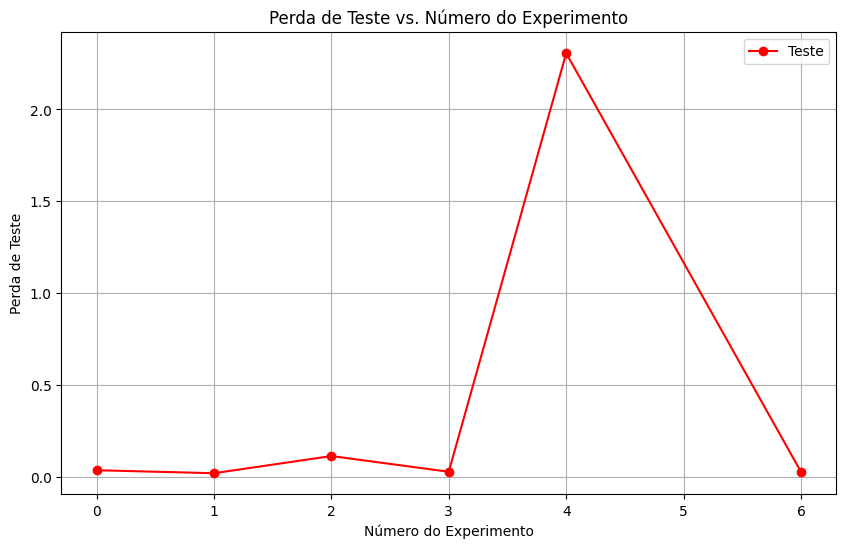

In [49]:
plt.figure(figsize=(10, 6))
plt.plot(df['number'], df['user_attrs_test_loss'], marker='o', linestyle='-', color='red')
plt.xlabel('Número do Experimento')
plt.ylabel('Perda de Teste')
plt.title('Perda de Teste vs. Número do Experimento')
plt.legend(['Teste'])
plt.grid(True)
plt.show()

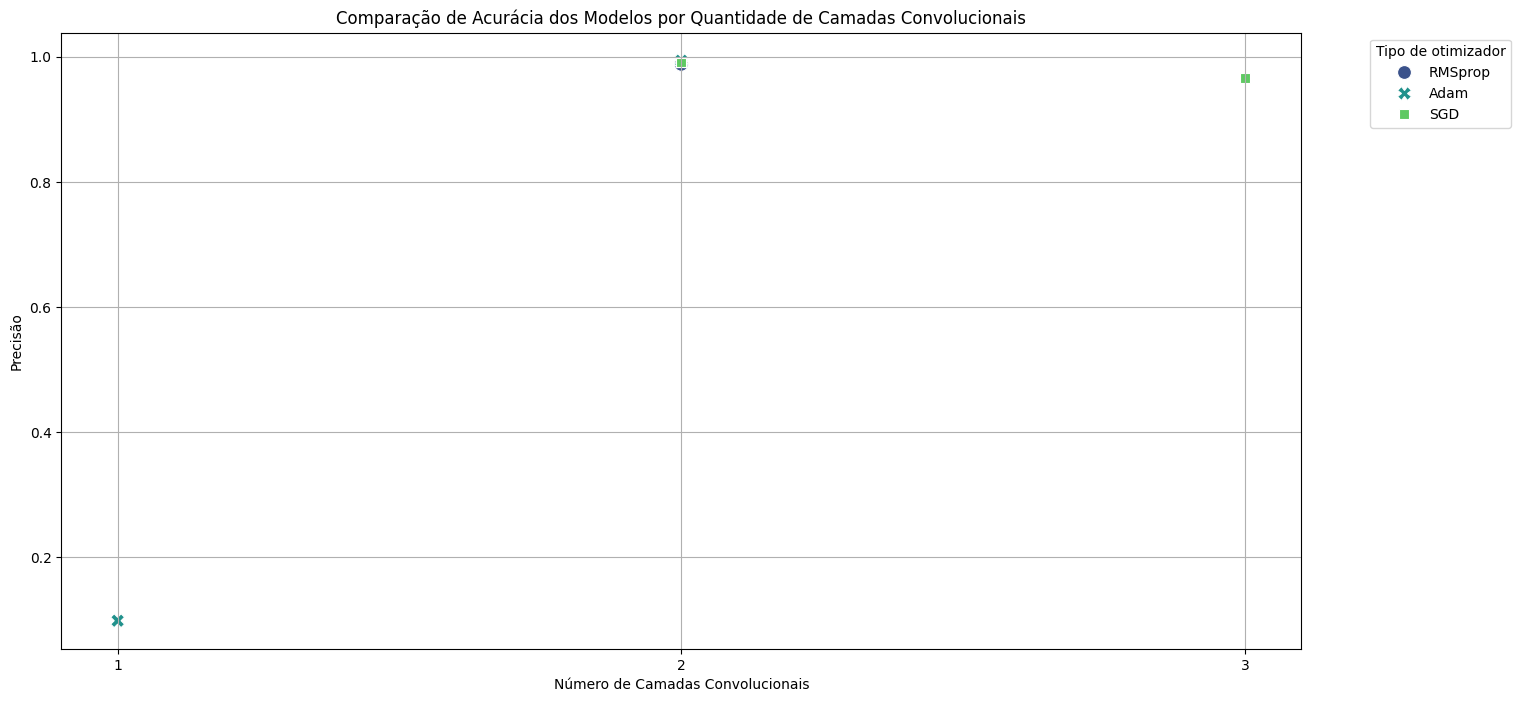

In [50]:
plt.figure(figsize=(16, 8))

sns.scatterplot(data=df, x='params_num_conv_layers', y='user_attrs_accuracy', hue='params_optimizer', style='params_optimizer', markers=True,
                palette='viridis', s=100)

plt.title('Comparação de Acurácia dos Modelos por Quantidade de Camadas Convolucionais')
plt.xlabel('Número de Camadas Convolucionais')
plt.ylabel('Precisão')
plt.xticks(df['params_num_conv_layers'].unique())
plt.grid(True)
plt.legend(title='Tipo de otimizador', bbox_to_anchor=(1.05, 1), loc='upper left')  # Movendo a legenda para fora do gráfico

plt.show()

In [51]:
data = pd.DataFrame(df.groupby('params_num_conv_layers')['user_attrs_accuracy'].mean().reset_index())

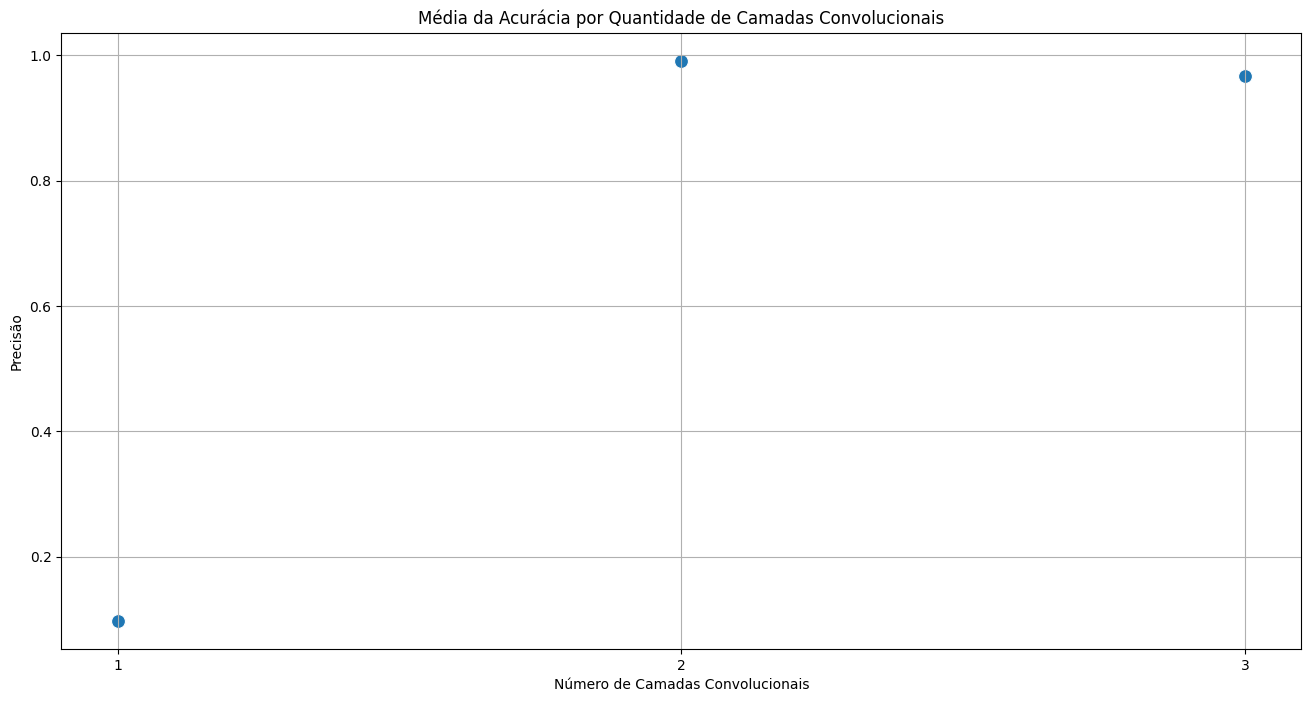

In [52]:
plt.figure(figsize=(16, 8))

sns.scatterplot(data=data, x='params_num_conv_layers', y='user_attrs_accuracy', markers=True,
                 s=100)

plt.title('Média da Acurácia por Quantidade de Camadas Convolucionais')
plt.xlabel('Número de Camadas Convolucionais')
plt.ylabel('Precisão')
plt.xticks(df['params_num_conv_layers'].unique())
plt.grid(True)

plt.show()

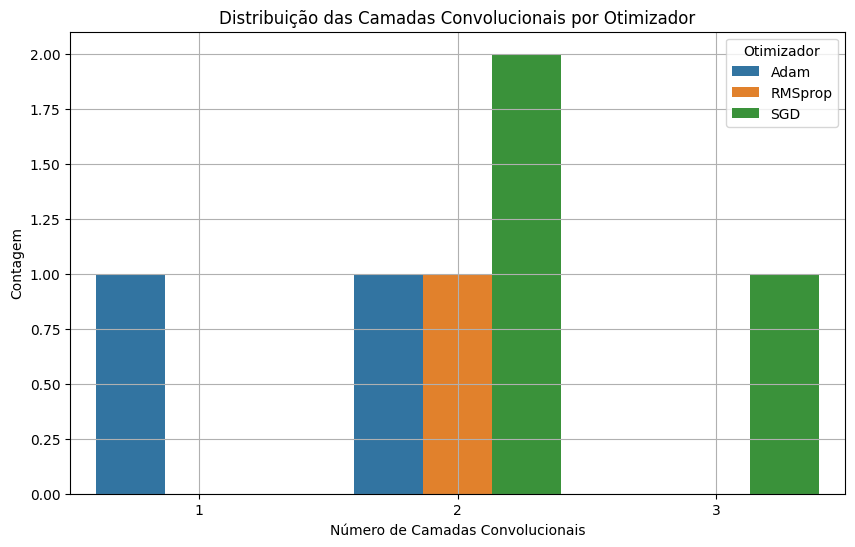

In [53]:

plt.figure(figsize=(10, 6))
sns.countplot(x='params_num_conv_layers', hue='params_optimizer', data=df)
plt.title('Distribuição das Camadas Convolucionais por Otimizador')
plt.xlabel('Número de Camadas Convolucionais')
plt.ylabel('Contagem')
plt.legend(title='Otimizador')
plt.grid(True)
plt.show()

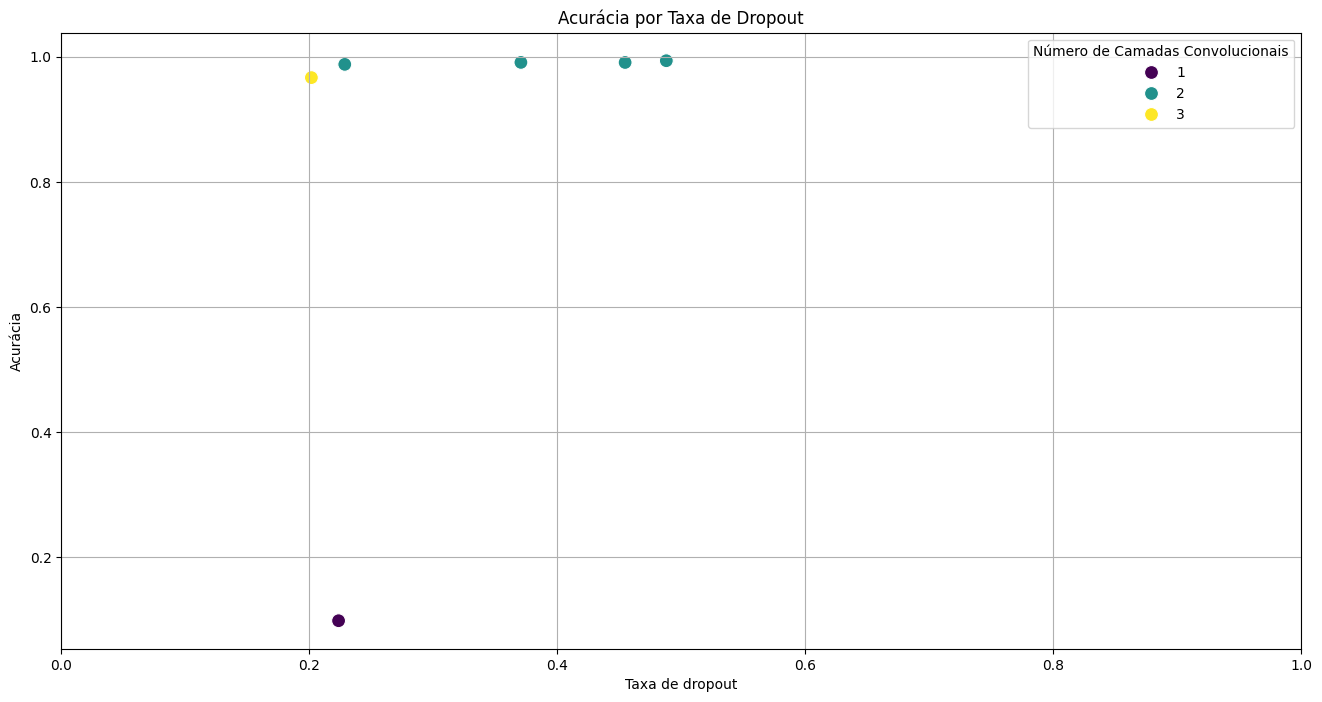

In [54]:
plt.figure(figsize=(16, 8))

sns.scatterplot(data=df, x='params_drop_conv2', y='user_attrs_accuracy', hue='params_num_conv_layers', palette='viridis'
                , s=100)

plt.title('Acurácia por Taxa de Dropout')
plt.xlabel('Taxa de dropout')
plt.ylabel('Acurácia')
plt.xlim(0.0, 1)
plt.grid(True)
plt.legend(title='Número de Camadas Convolucionais', loc='upper right')

plt.show()